<a href="https://colab.research.google.com/github/Alakhras/Abalone-Age/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification using Tensorflow and Keras
Aladdin Alakhras, University of Missouri-St. Louis

### **Problem:**
* Abalones are endangered marine snails found in cold coastal waters worldwide,  Their price is positively correlated with age.
  However, determining abalone age is complex.
A machine learning model to classify abalone age would significantly accelerate this manual process, benefiting abalone researchers and adding value to the field.

* Dataset: [`Abalone.csv`](https://github.com/Alakhras/Abalone-Age/blob/main/Abalone.csv)
  - This project classifies abalone snails as "young" or "old" based on their ring count, using input features such as gender, height, weight, etc.
* Original data at [UCI ML database](https://archive.ics.uci.edu/dataset/1/abalone)

#Phase 1: Exploratory Data Analysis & preparation of the Abalone Data Set


  We are going to use physical and biological attributes of abalone to predict whether an abalone is old or young. There are 4177 observations in this data set and 8 features. We have sex as a categorical feature indicating whether an abalone is male, female or infant. We have other 7 numeric features which describe the size and weight of abalones.
The missing values have been removed in the original research so we do not have missing values here.


#Step 1: Load the Dataset, Clean It, and Preview Its Shape and the First 5 Rows#



In [6]:
import os
import shap
import random
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from IPython.display import display, Markdown
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [50]:
BASE_PATH = 'https://raw.githubusercontent.com/Alakhras/Abalone-Age/main/Abalone.csv'
dataset1 = pd.read_csv(BASE_PATH)
print(dataset1.shape)
dataset1.head()


(4177, 9)


Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

The minimum value in height is **zero**.
There are only two rows with **zero** values. We can remove these two rows from our dataset and consider the rest of the data for the model.

In [51]:
dataset2 = dataset1[dataset1.Height != 0]
print(dataset2.shape)
dataset2.describe()



(4175, 9)


Length    Diameter       Height  Whole weight  Shucked weight  \
count  4175.000000  4175.00000  4175.000000   4175.000000     4175.000000   
mean      0.524065     0.40794     0.139583      0.829005        0.359476   
std       0.120069     0.09922     0.041725      0.490349        0.221954   
min       0.075000     0.05500     0.010000      0.002000        0.001000   
25%       0.450000     0.35000     0.115000      0.442250        0.186250   
50%       0.545000     0.42500     0.140000      0.800000        0.336000   
75%       0.615000     0.48000     0.165000      1.153500        0.502000   
max       0.815000     0.65000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4175.000000   4175.000000  4175.000000  
mean         0.180653      0.238834     9.935090  
std          0.109605      0.139212     3.224227  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.000000  
50%          0.171000      0.234000     9.000000  
75%          0.253000      0.328750    11.000000  
max          0.760000      1.005000    29.000000

*  Step 2: Prepare the output
*  Step 3: Shuffle the rows
*  Step 4: Split into Training/Validation Set

We categorize abalones based on their age, designating those with more than 10 rings as "old" and those with 10 rings or fewer as "young." This threshold is arbitrary, and we observe an imbalanced distribution of the target variable, which could affect our predictive modeling efforts. Addressing this imbalance is crucial for improving model performance and ensuring reliable classifications.

In [52]:
dataset2["Is old"] = np.where(dataset2["Rings"] > 10, "Old", "Young")
dataset2.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings Is old  
0         0.150     15    Old  
1         0.070      7  Young  
2         0.210      9  Young  
3         0.155     10  Young  
4         0.055      7  Young

Then check if the data is imbalanced by calculating what percentage of the output labels are 0 and what percentage are 1 which is:

| Target       | Old | Young |
| -------------| --- | ---   |
| Observations | 1447| 2730  |.
| Percentage   | 35% | 65%   |.

The dataset exhibits some imbalance but is sufficiently balanced for our analysis, allowing us to proceed with our modeling efforts.


##Shuffling the dataset for reliability
###Convert 'Sex' and 'Is old' columns to numeric representation


In [53]:
# Shuffle the dataset
dataset2 = dataset2.sample(frac=1).reset_index(drop=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
# Convert 'Sex' column to numeric representation
dataset2['Sex'] = dataset2['Sex'].map({'M': 1, 'F': 0, 'I': 2}).astype(float)  # Apply astype(float) to the Series after mapping
#Convert 'Is old' column to numeric representation
dataset2['Is old'] = dataset2['Is old'].map({'Old': 1, 'Young': 0}).astype(float)  # Apply astype(float) to the Series after mapping
#dataset = dataset2.to_numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(dataset2[0:5, :])



[[2.00 0.37 0.27 0.10 0.22 0.10 0.05 0.07 6.00 0.00]
 [2.00 0.40 0.29 0.10 0.30 0.16 0.07 0.08 7.00 0.00]
 [1.00 0.72 0.57 0.20 1.83 0.92 0.37 0.48 10.00 0.00]
 [2.00 0.60 0.49 0.14 1.05 0.37 0.23 0.36 12.00 1.00]
 [0.00 0.64 0.52 0.20 1.53 0.66 0.33 0.40 9.00 0.00]]


##Split into Training/Validation Set

In [54]:
XTRAIN, XVALIDATION = train_test_split(dataset2, test_size=0.2, random_state=123)

In [37]:
index_20percent = int(0.2 * len(dataset2))  # Get 20% of the total number of rows
print(index_20percent)
XVALIDATION = dataset2.iloc[:index_20percent, :-1].values
YVALIDATION = dataset2.iloc[:index_20percent, -1].values

XTRAIN = dataset2.iloc[index_20percent:, :-1].values
YTRAIN = dataset2.iloc[index_20percent:, -1].values

835


*   Step 5: Normalize (if needed)
*   Step 6: Review the dimensions of training & validation set


###Exploratory data analysis on training & validation sets

#### 3.1 Target variable distribution
Exploratory data analysis gives us a basic understanding of our train and validation data, and we may also find the some useful features to make young-old prediction for abalones. First, we plot the distribution of our target variable. The young-old class is derived from rings, so we also include the distribution of rings into our plot. From the figure we can observe a slightly right skewed distribution of `rings`. Since we set the threshold for old abalone as `rings > 11` , we get an unbalanced distribution of old and young abalone.

In [86]:
# Distribution of our target: rings and is_old
alt.Chart(XTRAIN, title="Distribution of target variables").mark_bar().encode(
    alt.X(alt.repeat(), type="nominal"),
    alt.Y("count()")
).repeat(["Rings", "Is old"])

alt.RepeatChart(...)

#### 3.2 Distribution of categorical variable
Sex is the only categorical variable in this data set. It has three categories: male, female and infant, denoted as M, F, I respectively. The distribution of sex is balanced.

In [87]:
# Distribution of categorical variable: sex
alt.Chart(XTRAIN, title="Distribution of sex").mark_bar().encode(
    alt.Y("Sex"), alt.X("count()")
)

alt.Chart(...)

#### 3.3 Distribution of continuous variables
We first get a summary table from our data set. However, this table does not contain intuitive information to help us make prediction.

In [59]:
XTRAIN.describe()

Sex       Length     Diameter       Height  Whole weight  \
count  3340.000000  3340.000000  3340.000000  3340.000000   3340.000000   
mean      1.003293     0.522928     0.407046     0.139388      0.825860   
std       0.799252     0.120507     0.099628     0.042698      0.491321   
min       0.000000     0.075000     0.055000     0.010000      0.002000   
25%       0.000000     0.450000     0.345000     0.115000      0.438000   
50%       1.000000     0.540000     0.420000     0.140000      0.797500   
75%       2.000000     0.615000     0.480000     0.165000      1.147250   
max       2.000000     0.815000     0.650000     1.130000      2.825500   

       Shucked weight  Viscera weight  Shell weight        Rings       Is old  
count     3340.000000     3340.000000   3340.000000  3340.000000  3340.000000  
mean         0.358095        0.180130      0.237990     9.900599     0.339222  
std          0.222770        0.109757      0.139592     3.208862     0.473516  
min          0.001000        0.000500      0.001500     1.000000     0.000000  
25%          0.181500        0.091500      0.128750     8.000000     0.000000  
50%          0.334000        0.170500      0.231000     9.000000     0.000000  
75%          0.501625        0.252500      0.327750    11.000000     1.000000  
max          1.488000        0.641500      0.897000    29.000000     1.000000

Then we plot the distribution of all numeric features within two targeted classes.From the plot we can group the numeric variables into three groups: (length, diameter), (height), and (whole_weight, shucked_weight, viscera_weight, shell_weight).  
The first group is left skewed. The means of two classes are similar and the old abalones have less deviation from mean.The second group has some outliers and the third group is right skewed. In the third group, we can observe a difference in mean weights and the distribution of old abalones are more bell-shaped.

In [60]:
# Distribution of numeric variables: 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'
alt.Chart(XTRAIN, title="Distribution of numeric variables").mark_bar(
    opacity=0.5
).encode(
    alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=50)),
    alt.Y("count()", stack=None),
    color=alt.Color("Is old:O", scale=alt.Scale(range=['#2ca02c', '#d62728']))  # Custom ordinal color palette
).repeat(
    [
        "Length",
        "Diameter",
        "Height",
        "Whole weight",
        "Shucked weight",
        "Viscera weight",
        "Shell weight",
    ],
    columns=2,
)

alt.RepeatChart(...)

####3.4 Correlation Analysis with Target Variable
In our analysis, we aim to explore the correlation between the selected predictor variables—length, height, and whole weight—and the target variable, rings. Our focus is also on identifying potential differences between young and old abalones.

Preliminary observations indicate a noticeable distinction in the regression lines when analyzing the relationships between the predictor variables (length and whole weight) and the target variable (rings) across the two classes. This suggests that the age classification of abalones may influence their physical characteristics and, consequently, their correlation with the number of rings.

In [61]:
# Base scatter plot for Length vs. Rings
point_length = (
    alt.Chart(
        XTRAIN,
        title="A Difference in Correlation Between Length and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X("Length:Q", title="Length"),
        y=alt.Y("Rings:Q", title="Rings"),
        color=alt.Color("Is old:N", title="Is Old")  # Ensure 'Is old' is treated as nominal
    )
)

# Regression lines for each group
regression_lines = point_length.transform_regression(
    "Length", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_length + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

In [62]:
# Base scatter plot for Height vs. Rings
point_height = (
    alt.Chart(
        XTRAIN,
        title="A Difference in Correlation Between Height and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.2)
    .encode(
        x=alt.X("Height:Q", title="Height"),
        y=alt.Y("Rings:Q", title="Rings"),
        color=alt.Color("Is old:N", title="Is Old")  # Ensure 'Is old' is treated as nominal
    )
)

# Regression lines for each group
regression_lines = point_height.transform_regression(
    "Height", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_height + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

In [63]:
# Base scatter plot for Whole Weight vs. Rings
point_weight = (
    alt.Chart(
        XTRAIN,
        title="A Difference in Correlation Between Whole Weight and Rings for Old and Young Abalones",
    )
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X("Whole weight:Q", title="Whole Weight"),  # Ensure whole weight is treated as quantitative
        y=alt.Y("Rings:Q", title="Rings"),                # Ensure rings is treated as quantitative
        color=alt.Color("Is old:N", title="Is Old")       # Treat 'Is old' as nominal
    )
)

# Regression lines for each group
regression_lines = point_weight.transform_regression(
    "Whole weight", "Rings", groupby=["Is old"]
).mark_line(color="red")

# Combine scatter plot and regression lines
combined_chart = point_weight + regression_lines

# Display the combined chart
combined_chart.display()

alt.LayerChart(...)

#### 3.5 Scatter Plots Showing the Relationship Between Continuous Features
We expect collinearity among the numeric features. Size measurements—length, diameter, and height—are strongly correlated with each other and also correlate with weight. This can be a concern for models sensitive to highly correlated features.

In the first group of scatter plots, we see that length, diameter, and height are linearly correlated. The relationship between size and weight, however, appears to be more non-linear. In the second group of scatter plots focused on weight, the correlations among weight features exist but are generally weaker than those among size features. The relationship between weight and age (rings) is not very clear, but there seems to be a slight positive correlation, suggesting that older abalones may weigh more.


In [64]:
# Define the features to compare
features = ["Length", "Diameter", "Height", "Whole weight"]

# Create a scatter plot matrix for the specified features
scatter_matrix = alt.Chart(XTRAIN, title="Scatter Plot Matrix of Numeric Variables").mark_point(
    size=5, opacity=0.1
).encode(
    x=alt.X(alt.repeat("row"), type="quantitative"),
    y=alt.Y(alt.repeat("column"), type="quantitative"),
).properties(
    height=200, width=200
).repeat(
    row=features,  # Rows correspond to features for the y-axis
    column=features  # Columns correspond to features for the x-axis
)

# Display the scatter plot matrix
scatter_matrix.display()

alt.RepeatChart(...)

In [65]:
# Define the features to compare
features = ["Shucked weight", "Viscera weight", "Shell weight", "Rings"]

# Create a scatter plot matrix for the specified features
scatter_matrix = alt.Chart(XTRAIN, title="Scatter Plot Matrix of Numeric Variables").mark_point(
    size=5, opacity=0.1
).encode(
    x=alt.X(alt.repeat("column"), type="quantitative"),  # X-axis uses features for columns
    y=alt.Y(alt.repeat("row"), type="quantitative"),     # Y-axis uses features for rows
).properties(
    height=200, width=200
).repeat(
    column=features,  # Columns correspond to features for the x-axis
    row=features      # Rows correspond to features for the y-axis
)

# Display the scatter plot matrix
scatter_matrix.display()

alt.RepeatChart(...)

#### 3.6 Correlation Heat Map
A correlation heat map offers a visually intuitive representation of the relationships between all variables in our dataset. By examining the heat map, we can identify that the feature variables exhibit high levels of correlation. This visualization allows us to easily discern patterns and potential multicollinearity among the numeric features, which is critical for informing our modeling decisions and understanding the underlying data structure.

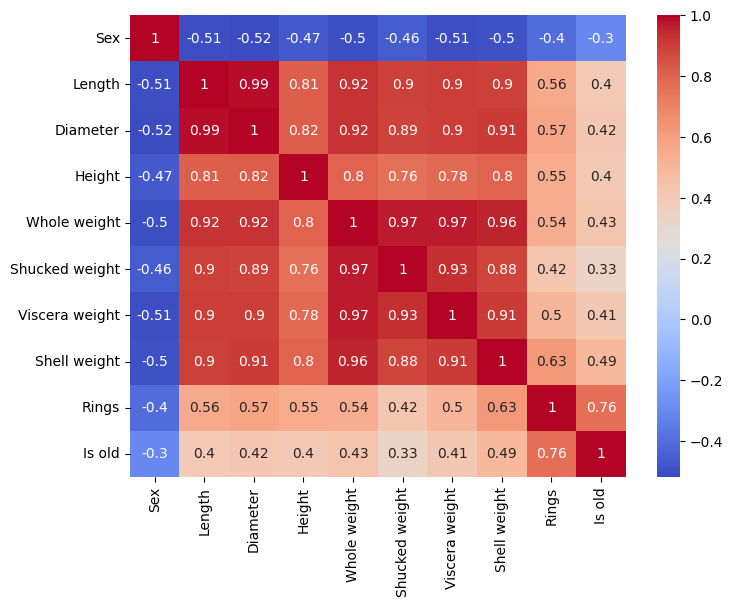

In [82]:
# Calculate the correlation matrix only for numeric columns.
plt.figure(figsize=(8, 6))  # Adjust the figure size if desired
sns.heatmap(XTRAIN.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.show()

##Normalize the dataset

835


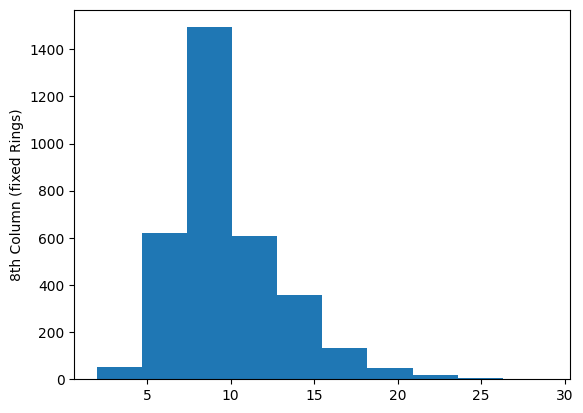

0      1      2      3       4       5       6      7     8
0  0.0  0.535  0.415  0.185  0.8415  0.3140  0.1585  0.300  15.0
1  2.0  0.285  0.210  0.070  0.1090  0.0440  0.0265  0.033   5.0
2  2.0  0.535  0.400  0.135  0.6025  0.2895  0.1210  0.154   9.0
3  2.0  0.415  0.320  0.110  0.3735  0.1750  0.0755  0.109   7.0
4  2.0  0.505  0.355  0.125  0.6010  0.2500  0.1205  0.185   8.0

In [95]:
dataset = dataset2
index_20percent = int(0.2 * len(dataset))  # Get 20% of the total number of rows
print(index_20percent)
XVALIDATION = dataset.iloc[:index_20percent, :-1].values
YVALIDATION = dataset.iloc[:index_20percent, -1].values

XTRAIN = dataset.iloc[index_20percent:, :-1].values
YTRAIN = dataset.iloc[index_20percent:, -1].values
plt.hist(XTRAIN[:, 8])
plt.ylabel('8th Column (fixed Rings)')
plt.show()
XTRAIN_df = pd.DataFrame(XTRAIN)
XTRAIN_df.head()

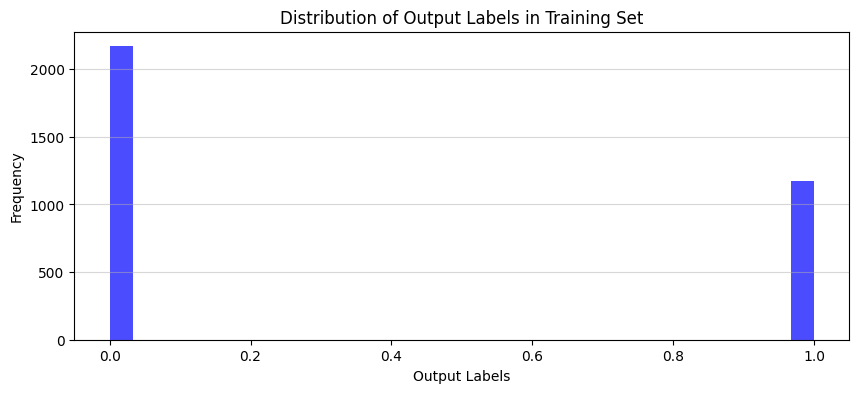

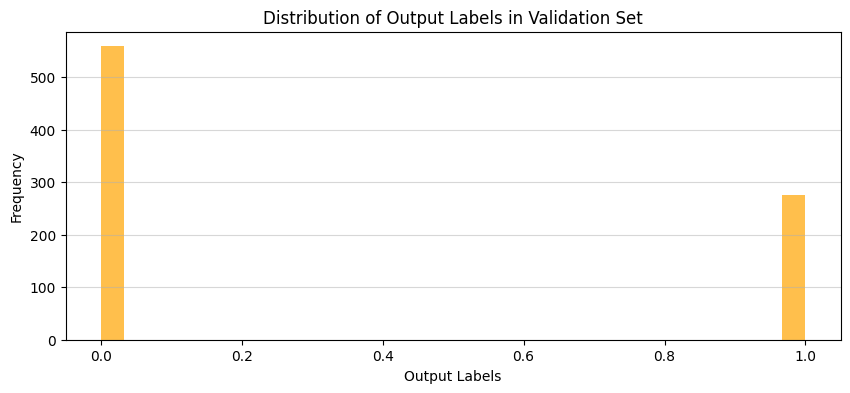

In [96]:
# Histogram for training set output labels
plt.figure(figsize=(10, 4))  # Set figure size
plt.hist(YTRAIN, bins=30, color='blue', alpha=0.7)  # Adjust number of bins and color
plt.title('Distribution of Output Labels in Training Set')  # Title for the histogram
plt.xlabel('Output Labels')  # X-axis label
plt.ylabel('Frequency')      # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

# Histogram for validation set output labels
plt.figure(figsize=(10, 4))  # Set figure size
plt.hist(YVALIDATION, bins=30, color='orange', alpha=0.7)  # Adjust number of bins and color
plt.title('Distribution of Output Labels in Validation Set')  # Title for the histogram
plt.xlabel('Output Labels')  # X-axis label
plt.ylabel('Frequency')      # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

In [101]:
# Normalize features only for the training set
X_min = np.min(XTRAIN, axis=0)
X_max = np.max(XTRAIN, axis=0)
X_TRAIN_normalized = (XTRAIN - X_min) / (X_max - X_min)

X_VALIDATION_normalized = (XVALIDATION - X_min) / (X_max - X_min)  # Use the same min and max to scale test data

all_features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
XTRAIN_df = pd.DataFrame(X_TRAIN_normalized, columns=all_features)
XTRAIN_df.head()

Sex    Length  Diameter    Height  Whole weight  Shucked weight  \
0  0.0  0.615942  0.601852  0.152466      0.295830        0.209694   
1  1.0  0.253623  0.222222  0.049327      0.035847        0.027937   
2  1.0  0.615942  0.574074  0.107623      0.211003        0.193201   
3  1.0  0.442029  0.425926  0.085202      0.129725        0.116123   
4  1.0  0.572464  0.490741  0.098655      0.210470        0.166611   

   Viscera weight  Shell weight     Rings  
0        0.208032      0.332215  0.481481  
1        0.034233      0.033557  0.111111  
2        0.158657      0.168904  0.259259  
3        0.098749      0.118568  0.185185  
4        0.157999      0.203579  0.222222

In [98]:
# Print shapes of the datasets
print("Shapes of the datasets:")
print("XTRAIN shape:", XTRAIN.shape)
print("YTRAIN shape:", YTRAIN.shape)
print("X_VALIDATION_normalized shape:", X_VALIDATION_normalized.shape)
print("X_TRAIN_normalized shape:", X_TRAIN_normalized.shape)
print("YVALIDATION shape:", YVALIDATION.shape)

# Print first three rows of each dataset
print("\nFirst three entries of the datasets:")
print("XTRAIN (first 3 rows):")
print(XTRAIN[0:3,])  # Assuming XTRAIN is a NumPy array
print("YTRAIN (first 3 entries):")
print(YTRAIN[0:3])

print("\nX_VALIDATION_normalized (first 3 rows):")
print(X_VALIDATION_normalized[0:3,])  # Assuming X_VALIDATION_normalized is a NumPy array
print("X_TRAIN_normalized (first 3 rows):")
print(X_TRAIN_normalized[0:3,])  # Assuming X_TRAIN_normalized is a NumPy array

print("\nYVALIDATION (first 3 entries):")
print(YVALIDATION[0:3])  # Assuming YVALIDATION is a NumPy array

Shapes of the datasets:
XTRAIN shape: (3340, 9)
YTRAIN shape: (3340,)
X_VALIDATION_normalized shape: (835, 9)
X_TRAIN_normalized shape: (3340, 9)
YVALIDATION shape: (835,)

First three entries of the datasets:
XTRAIN (first 3 rows):
[[0.00 0.54 0.41 0.18 0.84 0.31 0.16 0.30 15.00]
 [2.00 0.28 0.21 0.07 0.11 0.04 0.03 0.03 5.00]
 [2.00 0.54 0.40 0.14 0.60 0.29 0.12 0.15 9.00]]
YTRAIN (first 3 entries):
[1.00 0.00 0.00]

X_VALIDATION_normalized (first 3 rows):
[[0.50 0.71 0.70 0.13 0.36 0.30 0.26 0.34 0.30]
 [0.00 0.78 0.84 0.13 0.55 0.45 0.45 0.46 0.52]
 [0.50 0.66 0.65 0.14 0.32 0.21 0.25 0.36 0.44]]
X_TRAIN_normalized (first 3 rows):
[[0.00 0.62 0.60 0.15 0.30 0.21 0.21 0.33 0.48]
 [1.00 0.25 0.22 0.05 0.04 0.03 0.03 0.03 0.11]
 [1.00 0.62 0.57 0.11 0.21 0.19 0.16 0.17 0.26]]

YVALIDATION (first 3 entries):
[0.00 1.00 1.00]


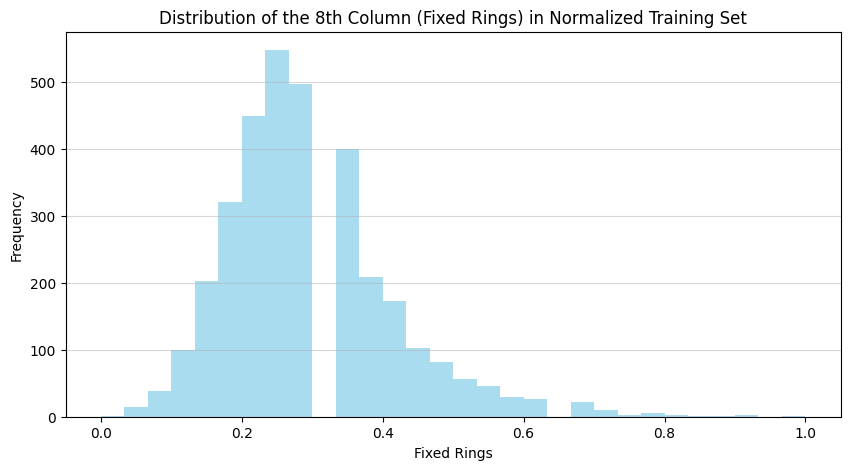

In [99]:
# Plot histogram for the 8th column of the normalized training set
plt.figure(figsize=(10, 5))  # Set figure size for better visibility
plt.hist(X_TRAIN_normalized[:, 8], bins=30, color='skyblue', alpha=0.7)  # Specify the number of bins and colors
plt.title('Distribution of the 8th Column (Fixed Rings) in Normalized Training Set')  # Title for the histogram
plt.xlabel('Fixed Rings')  # X-axis label
plt.ylabel('Frequency')     # Y-axis label
plt.grid(axis='y', alpha=0.5)  # Optional grid for better readability
plt.show()

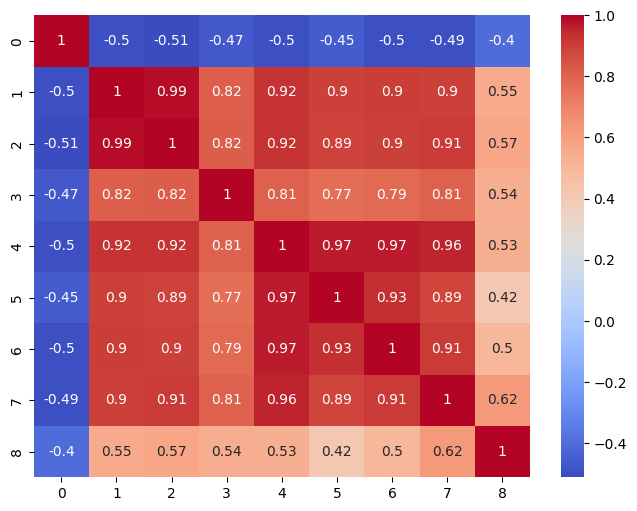

In [100]:
# Calculate the correlation matrix only for numeric columns.
dataset_df = pd.DataFrame(X_TRAIN_normalized)
plt.figure(figsize=(8, 6))  # Adjust the figure size if desired
sns.heatmap(dataset_df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.show()

###Phase 2: Build a model to overfit the entire dataset


*   Step 7: Create a neural network model
*   Step 8: Compile the model
*   Step 9: Train the model
*   Step 10: Check the learning curves
*   Step 11: Evaluate the model on the dataset
*   Step 13: Check what what the model actually predicts
*   Step 14: Is 'accuracy' sufficient to evaluate our model?


we want to determine how big architecture we need to overfit the data. The place to start is to use ‘logistic regression’ model and train for as many epochs as needed to obtain as high accuracy as possible so we will use the dataset without splitting then normalize it.

In [108]:
# Separate features and target
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Normalize features
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_normalized = (X - X_min) / (X_max - X_min)

#Model Creation and Training:
 The function create_compile_model initializes a neural network based on specified architecture. The initial model is set up as a logistic regression with one neuron. Training the model produces learning curves that illustrate how loss and accuracy evolve over epochs, providing insights into model performance.


In [113]:
# 1. Model Creation and Training: A function to create and compile a neural network model is defined, allowing for flexibility in architecture.
def create_compile_model(input_shape, layers):
    model = Sequential()  # Initialize a Sequential model
    for i, neurons in enumerate(layers):
        if i == 0:
            model.add(Dense(neurons, input_shape=input_shape, activation='relu'))  # Input layer with ReLU activation
        else:
            model.add(Dense(neurons, activation='relu'))  # Hidden layers with ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# The initial model starts as a logistic regression model (1 neuron)
model = create_compile_model((X_normalized.shape[1],), [1])

# After training, the learning curves for both loss and accuracy are plotted to visualize the model's performance.
history = model.fit(X_normalized, y, epochs=100, verbose=1)



Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6616 - loss: 0.6889
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6874 - loss: 0.6713
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7194 - loss: 0.6516
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7177 - loss: 0.6362
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7376 - loss: 0.6212
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7354 - loss: 0.6094
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7457 - loss: 0.5945
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.5805
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7537 - loss: 0.5661
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7839 - loss: 0.5542
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7751 - loss: 0.5439
Epoch 12/100
131/131 ━━━━━━━━━━━━━━━━━━━━

#Evaluation:
After training, the model is evaluated on the entire dataset. Predictions are generated, enabling the calculation of accuracy, precision, recall, and F1 score. Displaying the first ten predictions alongside the actual values provides a direct comparison, allowing for assessment of prediction quality.

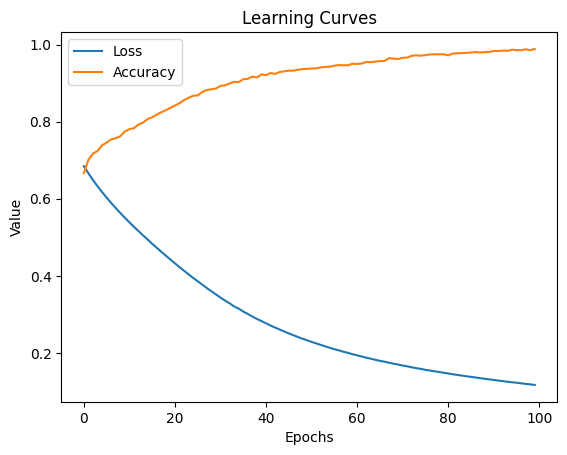



131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9877 - loss: 0.1152
Final accuracy on entire dataset: 98.73%


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predictions:         [0.23 1.00 1.00 0.01 0.01 0.04 0.54 0.01 0.04 1.00]
Binary Predictions:  [0.00 1.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00]
True Values:         [0.00 1.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00]
Precision:           0.98
Recall:              0.98
F1 Score:            0.98


In [114]:
# Plot learning curves
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()
print('\n')
# 2. Evaluation: The model is evaluated on the entire dataset, and predictions are made,
# followed by calculating additional metrics (precision, recall, and F1 score).
accuracy = model.evaluate(X_normalized, y, verbose=1)[1]
print(f'Final accuracy on entire dataset: {accuracy * 100:.2f}%')
print('\n')
# Check model predictions
predictions = model.predict(X_normalized).flatten()  # Get raw predictions
predictions_binary = np.round(predictions)  # Convert predictions to binary (0 or 1)
print('\n')
# Analyze predictions
print(f'Predictions:         {predictions[:10]}')
print(f'Binary Predictions:  {predictions_binary[:10]}')
print(f'True Values:         {y[:10]}')

# Additional Metrics
precision = precision_score(y, predictions_binary)
recall = recall_score(y, predictions_binary)
f1 = f1_score(y, predictions_binary)

print(f'Precision:           {precision:.2f}')
print(f'Recall:              {recall:.2f}')
print(f'F1 Score:            {f1:.2f}')

#Iterative Model Growth:
  The function iteratively_increase_model systematically tests various configurations of the neural network by varying the number of neurons in the hidden layer. The architectures tested include 2, 4, 8, 16, 32, and 64 neurons. Each configuration's accuracy is evaluated:

Architecture Evaluation: After fitting the model for each specified number of neurons, its accuracy is calculated. All tested architectures are logged for later review.
Overfitting Check: The evaluation stops if any architecture achieves an accuracy of 99.5%, which could indicate overfitting.
Summary of Results: After testing all configurations, a summary is printed to show the performance of each tested architecture and highlight the best-performing configuration. This iterative process aims to discover the optimal architecture that can overfit the dataset, which will later guide efforts to simplify the model for better generalization.
The function iteratively_increase_model tests various configurations by changing the number of neurons in the hidden layer. It tracks the accuracy for each architecture tested and identifies the configuration that performs best. The process stops when a model achieves at least 99.5% accuracy, indicating potential overfitting.

The function also records and prints a summary of results, detailing how each architecture performed, which is crucial in determining the minimal architecture needed to potentially overfit the dataset. Insights gained from this iterative growth will guide the process of model simplification for generalization in later phases.

In [116]:
# 3. Iterative Model Growth: A separate function is implemented to test various neuron configurations (2, 4, 8, 16 neurons).
def iteratively_increase_model():
    architectures_tested = []
    best_accuracy = 0
    best_architecture = None

    # Vary the number of neurons in simple iterative architectures
    for neurons in [2, 4, 8, 16, 32]:
        print(f"\nTesting architecture with {neurons} neurons")
        model = create_compile_model((X_normalized.shape[1],), [neurons])
        history = model.fit(X_normalized, y, epochs=500, verbose=0)  # Increase epochs for deeper training

        # Evaluate the model on the entire dataset
        accuracy = model.evaluate(X_normalized, y, verbose=0)[1]
        architectures_tested.append((neurons, accuracy * 100))

        print(f'Architecture with [{neurons}] neurons achieved accuracy: {accuracy * 100:.2f}%')

        # Check if this architecture overfits well
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_architecture = neurons

        # Break if exceeding 99% accuracy signifies overfitting
        if accuracy >= 0.995:
            print(f'Overfit achieved with architecture [{neurons}].\n')
            break
# Print summary of results
    print("\nSummary of model architectures tested:")
    for neurons, acc in architectures_tested:
        print(f'Neurons: {neurons}, Accuracy: {acc:.2f}%')

    print(f"\nBest Architecture: [{best_architecture}] neurons with accuracy {best_accuracy * 100:.2f}%")

# Run the architecture testing
iteratively_increase_model()


Testing architecture with 2 neurons
Architecture with [2] neurons achieved accuracy: 100.00%
Overfit achieved with architecture [2].


Summary of model architectures tested:
Neurons: 2, Accuracy: 100.00%

Best Architecture: [2] neurons with accuracy 100.00%


#Phase 3: Model selection & evaluation
*   Step 7: Create a neural network model
*   Step 8: Compile the model
*   Step 9: Train the model
*   Step 10: Check the learning curves
*   Step 11: Evaluate the model on the training data
*   Step 12: Evaluate on validation set
*   Step 13: Check what the model actually predicts
*   Step 14: Is 'accuracy' sufficient to evaluate our model?


#This code implements a machine learning workflow:
 that starts by defining and training a logistic regression model as a baseline for binary classification. It then evaluates multiple neural network architectures to improve performance, using ReLU activation in hidden layers and a sigmoid activation for the output layer. The models are trained and evaluated based on key metrics, including accuracy, precision, recall, and F1 score. Learning curves are plotted to visualize performance over epochs, and the best-performing model is saved using model checkpointing. Finally, a classification report summarizes the model's predictive capabilities, identifying the architecture that achieved the highest validation accuracy.

In [117]:
# Helper function to create neural network models
def create_model(layer_sizes):
    model = keras.Sequential()
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Baseline Logistic Regression Implementation
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y, epochs=1000, learning_rate=0.01):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        m = len(y)

        for _ in range(epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / m) * np.dot(X.T, (y_predicted - y))
            db = (1 / m) * np.sum(y_predicted - y)
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > 0.5).astype(int)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(XTRAIN, YTRAIN)
logistic_acc_train = np.mean(logistic_model.predict(XTRAIN) == YTRAIN)
logistic_acc_val = np.mean(logistic_model.predict(XVALIDATION) == YVALIDATION)

# Define neural network architectures to evaluate
model_architectures = [
    (2, 1),               # Model 1
    (4, 1),               # Model 2
    (8, 1),               # Model 3
    (16, 8, 1),           # Model 4
    (32, 16, 8, 1),       # Model 5
    (64, 32, 16, 8, 1),   # Model 6
]

# Store results in a list
results = []

# Model Checkpointing
checkpoint_path = 'best_model.keras'  # Change file extension to .keras
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Training and evaluating neural network models
for arch in model_architectures:
    model = create_model(arch)
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), epochs=50, batch_size=32, verbose=0, callbacks=[checkpoint])

    train_loss, train_acc = model.evaluate(XTRAIN, YTRAIN, verbose=0)
    val_loss, val_acc = model.evaluate(XVALIDATION, YVALIDATION, verbose=0)
    total_params = model.count_params()

    results.append((str(arch), train_acc, val_acc, train_loss, val_loss, total_params))



Epoch 1: val_loss improved from inf to 0.67966, saving model to best_model.keras

Epoch 2: val_loss improved from 0.67966 to 0.66871, saving model to best_model.keras

Epoch 3: val_loss improved from 0.66871 to 0.66011, saving model to best_model.keras

Epoch 4: val_loss improved from 0.66011 to 0.65379, saving model to best_model.keras

Epoch 5: val_loss improved from 0.65379 to 0.64882, saving model to best_model.keras

Epoch 6: val_loss improved from 0.64882 to 0.64527, saving model to best_model.keras

Epoch 7: val_loss improved from 0.64527 to 0.64264, saving model to best_model.keras

Epoch 8: val_loss improved from 0.64264 to 0.64064, saving model to best_model.keras

Epoch 9: val_loss improved from 0.64064 to 0.63933, saving model to best_model.keras

Epoch 10: val_loss improved from 0.63933 to 0.63833, saving model to best_model.keras

Epoch 11: val_loss improved from 0.63833 to 0.63751, saving model to best_model.keras

Epoch 12: val_loss improved from 0.63751 to 0.63691, sa

#Plot Learning Curves:
 Learning curves for each architecture are plotted to visualize how both training and validation accuracies evolve over epochs. This helps identify how well each model learns and if any of them are overfitting.

Load the Best Model: The model with the best performance (lowest validation loss) is loaded for final evaluation.

#Predictions and Metrics:
 Predictions are generated for the validation set using the best model. A custom classification report function calculates metrics such as accuracy, precision, recall, and F1 score based on the predictions, providing a detailed assessment of the model's predictive performance.

#Final Results:
The classification metrics are printed, summarizing the efficiency of the best model. Finally, it identifies which architecture performed best based on validation accuracy and prints this information.

This three-part structure effectively encompasses the workflow for logistic regression and neural network model definitions, training, evaluation, and performance reporting. If you have any further questions or need additional explanations, feel free to ask!

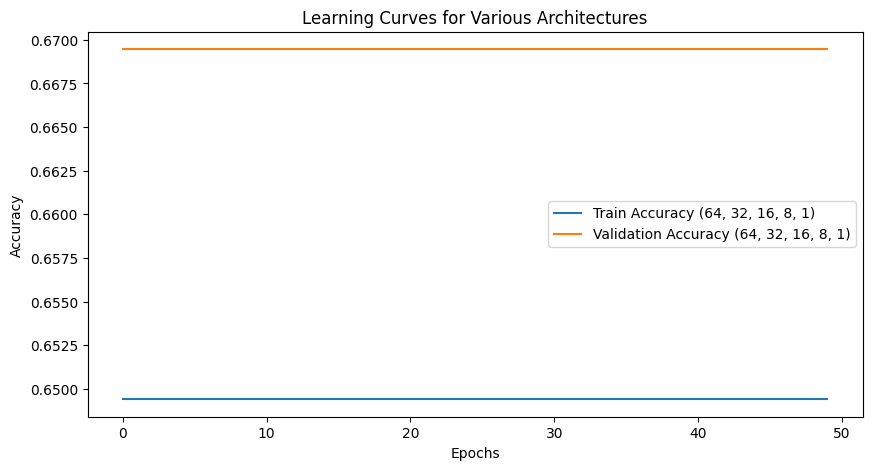

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Classification Report:
Accuracy: 465.4575
Precision: 0.3305
Recall: 0.3305
F1 Score: 0.3305


Logistic Regression - Training Accuracy   Validation Accuracy
                          0.7269               0.7219
Model Architecture  Training Accuracy  Validation Accuracy  Training Loss  Validation Loss  Total Parameters
            (2, 1)           0.649401             0.669461       0.647817         0.635457                25
            (4, 1)           0.989222             0.988024       0.130459         0.124149                47
            (8, 1)           0.997006             0.998802       0.078299         0.075329                91
        (16, 8, 1)           0.999102             0.998802       0.030124         0.028423               307
    (32, 16, 8, 1)           1.000000             1.000000       0.022761         0.023766               995
(64, 32, 16, 8, 1)           1.000000             1.000000       0.022748         0.023652     

In [118]:
# Plot Learning Curves
plt.figure(figsize=(10, 5))
for arch in model_architectures:
    model = create_model(arch) # The indentation of this line and the following line was incorrect. I have corrected it to align with the for loop
    history = model.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), epochs=50, batch_size=32, verbose=0)


# Plot learning curves
plt.plot(history.history['accuracy'], label='Train Accuracy ' + str(arch))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy ' + str(arch))

# Customize the plot
plt.title('Learning Curves for Various Architectures')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load the best model
best_model = keras.models.load_model(checkpoint_path)

# Make predictions and evaluate the best model on validation set
y_pred = (best_model.predict(XVALIDATION) > 0.5).astype(int)

# Custom classification report function
def classification_report(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0.0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# Evaluate the model using additional metrics
report = classification_report(YVALIDATION, y_pred)

# Print classification report
print('\n')
print("Classification Report:")
for key, value in report.items():
    print(f"{key}: {value:.4f}")
# Output results table
# Print logistic regression results
print('\n')
print("Logistic Regression - Training Accuracy   Validation Accuracy")
print(f"                          {logistic_acc_val:.4f}               {logistic_acc_train:.4f}")


results_df = pd.DataFrame(results, columns=['Model Architecture', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss', 'Total Parameters'])




# Print results in a single line
print(results_df.to_string(index=False))
# Conclusion about model performance
best_architecture = model_architectures[np.argmax([result[2] for result in results])]
print('\n')
print(f"The best performing model architecture is: {best_architecture} with validation accuracy: {max([result[2] for result in results]):.4f}")


#Discussion on Architecture Size for Overfitting with Output as an Additional Input Feature
When you incorporate the output variable as an extra input feature in your model, you’re essentially providing the model with more data to work with. This additional information can help the model identify more specific patterns and details in the training data.

In simpler terms, if you use a basic model with fewer layers and neurons, it may have trouble grasping the complexities of the data, particularly with this new input. On the other hand, more complex architectures—those with more layers and neurons—offer greater capacity for learning but come with the risk of overfitting.

To achieve overfitting, you might need a model with several hidden layers and a greater number of neurons in each layer (for instance, a structure like 64-32-16-8). Such a deeper network is likely necessary to effectively capture the relationships and dependencies that arise when including the output variable as input. However, it’s crucial to monitor the validation loss to verify whether overfitting truly occurs.

In [119]:
# Define your model architecture
def create_model(layer_sizes):
    model = keras.Sequential()
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom prediction function
def my_prediction_function(model, data):
    # Extract weights and bias from the model
    weights = [layer.get_weights()[0] for layer in model.layers[:-1]]  # All layers except output layer
    biases = [layer.get_weights()[1] for layer in model.layers[:-1]]   # All biases except output layer
    output_weights = model.layers[-1].get_weights()[0]  # Weights of output layer
    output_bias = model.layers[-1].get_weights()[1]  # Bias of output layer

    # Hidden layers
    z = XTRAIN  # Start with the input data
    for w, b in zip(weights, biases):
        z = np.dot(z, w) + b  # Linear transformation
        z = np.maximum(0, z)  # Apply ReLU activation

    # Output layer
    z = np.dot(z, output_weights) + output_bias  # Linear transformation for output
    result = 1 / (1 + np.exp(-z))  # Sigmoid activation for output
    return result.flatten()  # Ensure it returns a 1D array

# Example usage
# Define neural network architectures to evaluate
layer_sizes = [
    (2, 1),               # Model 1
    (4, 1),               # Model 2
    (8, 1),               # Model 3
    (16, 8, 1),           # Model 4
    (32, 16, 8, 1),       # Model 5
    (64, 32, 16, 8, 1),   # Model 6
]
#Loop through layer_sizes to select the first element of each tuple
updated_layer_sizes = [x[0] for x in layer_sizes] #selecting the first element of each tuple from layer_sizes and store it in a new list named updated_layer_sizes
model = create_model(updated_layer_sizes)

# (Assuming the model has already been trained)
# Now we can predict using both the model and the custom function
# Note: Replace XVALIDATION or any appropriate input data
train_predictions = model.predict(XTRAIN).flatten()
custom_predictions = my_prediction_function(model, XTRAIN)

# Check if predictions are approximately the same
assert np.allclose(train_predictions, custom_predictions), "Predictions do not match!"
print("Predictions from both methods are the same.")

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions from both methods are the same.


#Phase 4: Feature importance and reduction

#Define and Train Models for Each Feature Individually


Accuracies for individual features:
Sex: 0.6635
Length: 0.7257
Diameter: 0.7449
Height: 0.7377
Whole weight: 0.7437
Shucked weight: 0.7078
Viscera weight: 0.7257
Shell weight: 0.7653
Rings: 1.0000


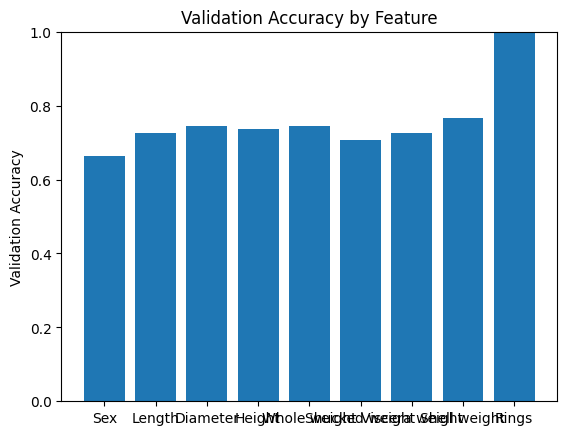

In [121]:
# Sample dataset loading
data = dataset2
# Data preparation
features = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
            'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
target = 'Is old'

# Prepare training and validation data
train_data = data.sample(frac=0.8, random_state=42)
val_data = data.drop(train_data.index)

X_train = train_data[features].to_numpy()
y_train = train_data[target].to_numpy()
X_val = val_data[features].to_numpy()
y_val = val_data[target].to_numpy()

# Function to create a simple model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(10, activation='relu', input_shape=(input_shape,)),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 2: Train models for each feature individually
accuracies = {}
model_checkpoints = []

for i, feature in enumerate(features):
    model = create_model(1)  # Model for one feature only
    checkpoint = ModelCheckpoint(f'model_{feature}.keras', monitor='val_accuracy', save_best_only=True, mode='max')
    model.fit(X_train[:, [i]], y_train, epochs=100, batch_size=5, verbose=0,
              validation_data=(X_val[:, [i]], y_val), callbacks=[checkpoint])
    loss, accuracy = model.evaluate(X_val[:, [i]], y_val, verbose=0)
    accuracies[feature] = accuracy
    model_checkpoints.append(checkpoint)
# Print accuracy for each feature
print("Accuracies for individual features:")
for feature, acc in accuracies.items():
    print(f"{feature}: {acc:.4f}")
# Plotting the accuracies of individual features
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy by Feature')
plt.show()



#Identify and Remove Least Important Features

In [122]:
# Step 3: Identify least important features and remove them incrementally
sorted_features = sorted(accuracies.items(), key=lambda x: x[1])
new_accuracies = []
remaining_features = features.copy()

for feature, _ in sorted_features:
    remaining_features.remove(feature)  # Remove the least important feature
    if remaining_features:  # Check if there are remaining features
     # Create and fit a new model with the remaining features
        model = create_model(len(remaining_features))
        checkpoint = ModelCheckpoint('reduced_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
        model.fit(X_train[:, [features.index(f) for f in remaining_features]], y_train,
                  epochs=100, batch_size=5, verbose=0,
                  validation_data=(X_val[:, [features.index(f) for f in remaining_features]], y_val),
                  callbacks=[checkpoint])

        # Evaluate the model
        loss, accuracy = model.evaluate(X_val[:, [features.index(f) for f in remaining_features]], y_val, verbose=0)
        new_accuracies.append((remaining_features.copy(), accuracy))
# Print the new accuracies
print("Accuracies after feature reduction:")
for feature_set, acc in new_accuracies:
        print(f"Features: {feature_set}, Accuracy: {acc:.4f}")


Accuracies after feature reduction:
Features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Viscera weight', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Diameter', 'Height', 'Whole weight', 'Viscera weight', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Diameter', 'Height', 'Whole weight', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Diameter', 'Whole weight', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Diameter', 'Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Shell weight', 'Rings'], Accuracy: 1.0000
Features: ['Rings'], Accuracy: 1.0000


#Plot the Results After Feature Reduction

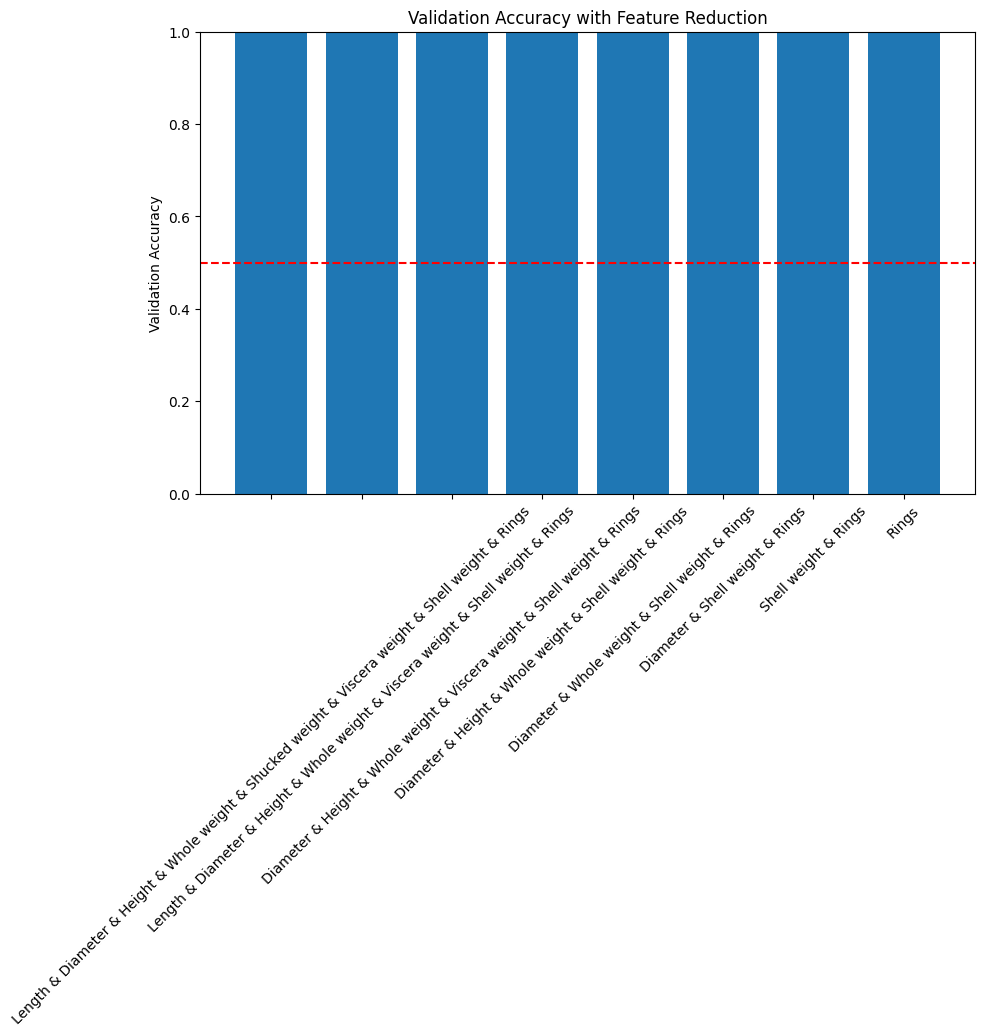

In [123]:
# Step 4: Plot the results after feature reduction
x_labels = [' & '.join(feature_set) for feature_set, acc in new_accuracies]
y_values = [acc for _, acc in new_accuracies]

plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values)
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy with Feature Reduction')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 accuracy
plt.show()

#Compare the Original Model with the Reduced Feature Model

In [124]:
# Step 5: Compare the original model with the reduced feature model
# Original model (using all features)
final_model = create_model(len(features))
checkpoint = ModelCheckpoint('final_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
final_model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0,
                validation_data=(X_val, y_val), callbacks=[checkpoint])

# Evaluate the original model
loss, original_accuracy = final_model.evaluate(X_val, y_val, verbose=0)

# Print the accuracies
print(f'Accuracy with all features: {original_accuracy:.4f}')


Accuracy with all features: 1.0000


#Accuracy of the Best Model After Feature Reduction

In [125]:
# Accuracy of the best model after feature reduction
if new_accuracies:
    reduced_accuracy = new_accuracies[-1][1]
    print(f'Best accuracy after feature reduction: {reduced_accuracy:.4f}')
else:
    print('No features remain after removal.')

Best accuracy after feature reduction: 1.0000


#Show Removed Features

In [126]:
# Optional: Show the features that were removed and the final accuracy of the reduced model
removed_features = [feature for feature in sorted_features]
print('Removed Features:', ', '.join([feature[0] for feature in removed_features]))

Removed Features: Sex, Shucked weight, Length, Viscera weight, Height, Whole weight, Diameter, Shell weight, Rings


#Use model-agnostic methods such as LIME or Shapley values to derive feature importance.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

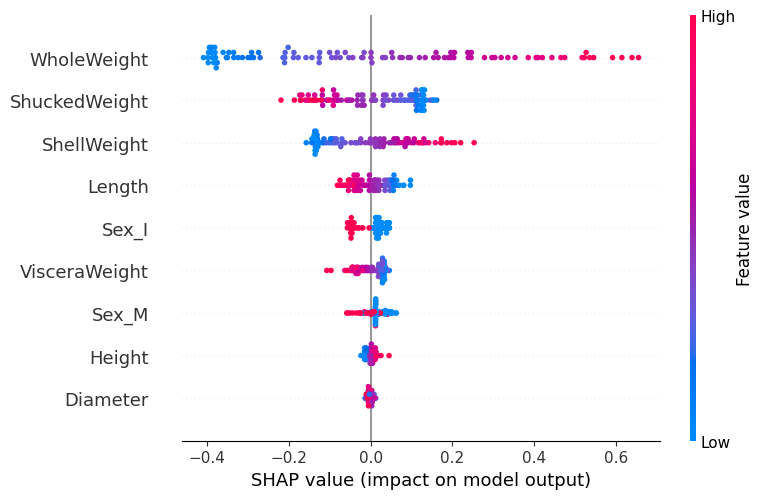

In [39]:
import pandas as pd
import numpy as np
import shap
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load the Abalone dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
columns = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight',
           'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
abalone_data = pd.read_csv(url, names=columns)

# Filter dataset: Keep only records with Rings > 1
abalone_data = abalone_data[abalone_data['Rings'] > 1]

# Convert 'Sex' into numerical values using one-hot encoding
abalone_data = pd.get_dummies(abalone_data, columns=['Sex'], drop_first=True)

# Separate features and target variable
X = abalone_data.drop('Rings', axis=1)  # Features
y = (abalone_data['Rings'] > 10).astype(int)  # Convert Rings into binary classification

# Split the dataset into training and validation sets
XTRAIN, XVALIDATION, YTRAIN, YVALIDATION = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Reduce datasets to 100 records
XTRAIN = XTRAIN[:100]
YTRAIN = YTRAIN[:100]
XVALIDATION = XVALIDATION[:100]
YVALIDATION = YVALIDATION[:100]  # Ensure this is 100 records

# Convert DataFrame columns to float32
XTRAIN = XTRAIN.astype(np.float32)
XVALIDATION = XVALIDATION.astype(np.float32)

# Step 2: Define the model architecture
final_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(XTRAIN.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

# Step 3: Compile the model
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss for your problem type

# Step 4: Train the final model using all features
final_model.fit(XTRAIN, YTRAIN, epochs=100, batch_size=5, verbose=0,
                validation_data=(XVALIDATION, YVALIDATION))

# Step 5: Analyze feature importance using SHAP
K = 100  # Choosing a smaller number of background samples
background_data = shap.sample(XTRAIN, K)  # Create background dataset
explainer = shap.KernelExplainer(final_model.predict, background_data)  # Create SHAP explainer
shap_values = explainer.shap_values(XVALIDATION)  # Compute SHAP values for validation data

# Reshape shap_values if it's a list (binary classification)
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Select the appropriate SHAP values

# Reshape shap_values to 2D if it's 3D
if shap_values.ndim == 3 and shap_values.shape[2] == 1:  # Reshape if 3D with single output
    shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])


# Step 6: Visualize SHAP values
shap.summary_plot(shap_values, XVALIDATION, feature_names=X.columns.tolist())  # Use feature names from DataFrame
shap.initjs()  # Initialize JavaScript for visualizations

# For force plot: prepare the first instance to explain
instance_to_explain = XVALIDATION.iloc[0].values.reshape(1, -1)  # Use .iloc to access the row by index
expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

# Create the force plot
shap.force_plot(expected_value, shap_values[0], instance_to_explain[0], feature_names=X.columns.tolist()) #Also added [0] to shap_values

### Step 15: Strategies for Improving Performance

1. **Technical Enhancements**:
   - **Increase Epochs**: One approach to enhance model performance is to increase the number of training epochs to 100 or 150. This will provide the model with additional time to learn from the data.
   - **Add Additional Layers**: Enhancing the complexity of the neural network by adding more layers can increase its learning capacity, allowing it to capture more intricate patterns in the data.

2. **Balance the Dataset**:
   - It is crucial to ensure that the dataset contains an equal number of samples for each class. You can achieve this through:
     - **Oversampling**: Utilize techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate additional samples for the minority class.
     - **Undersampling**: Reduce the number of samples in the majority class to maintain balance within the dataset.

3. **Adjust Training and Validation Set Size**:
   - Modify the number of records in your training and validation sets based on your needs:
     - **Increase Rows**: If your dataset is limited, consider gathering more data to augment it.
     - **Decrease Rows**: If the majority class has a disproportionately large number of records, reducing its size may help in achieving better balance and model performance.

4. **Geographical Location**: Including the locations where abalones are collected can help us understand how different environments affect their characteristics.

5. **Abalone Species**: Adding information about the species will allow us to account for biological differences that may impact classification.

6. **Color**: The color of abalones can vary, and using this feature can help the model better distinguish between different types.

7. **Number of Predators**: Knowing how many natural predators are in the area could provide insights into the abalones' health and behaviors, potentially influencing classification.

8. **Living Environment**: Features such as the type of habitat (e.g., rocky, sandy) and environmental conditions (like pollution and temperature) are crucial for understanding their characteristics.

By implementing these strategies, we can enhance the effectiveness of our classification model.


In [ ]:
#@title Convert ipynb to HTML in Colab
!jupyter nbconvert --to pdf AI_Final.ipynb